In [1]:
import numpy as np
import matplotlib.pyplot as plt
import betapic_c as bp
from kepler3 import *
from exorings3 import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
figsize_a4 = (8.3, 11.7) #a4
figsize_square_a4 = (8.3, 8.3)
figsize_half_a4 = (8.3 , 8.3/1.618)
figsize_2_1_a4 = (8.3, 8.3/2)

In [2]:
#vary this parameter for the mock data to get the CPD of different offsets from the set midpoint of the transit
offset_days = 40 #0,3,5,10,20,40

Hill sphere radius 0.3066705492565156 AU
Disk radius 0.2453364394052125 AU
Impact parameter distance 0.06133410985130312 AU
circular velocity at planet is 24.44432433015741 km / s
number of datapoints offset 80


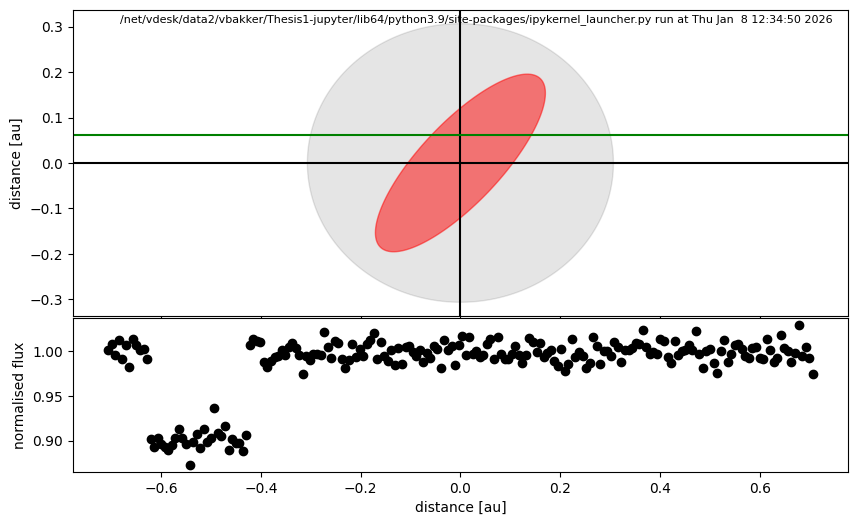

In [3]:
import os, sys
import datetime
runtime = os.path.abspath((sys.argv[0])) + " run at " + datetime.datetime.now().strftime("%c")
tyb = dict(color='black', fontsize=8)

# for a given tip and tilt, you can calculate the times where you cross that chord across the disk
# if you do hit that radius, you then split the photometry into 'yes we hit it' and 'no we don't'.

# then fit for the flux change between in eclipse and out of eclipse, come up with upper limit on tau.
# the graph is then a grid of points of tip and tilt, with upper limits on the mass of the disk in that configuration for a given radius of the disk.

t_mid = 58210. * u.day # time when star has closest approach to planet

r_hill = rhill(bp.M_star, bp.M_b, bp.a_b).to(u.au) # radius of hill sphere

print('Hill sphere radius {}'.format(r_hill))

f_hill = 0.80 # radius of disk in fraction of hill sphere

r_disk = r_hill * f_hill # radius of disk
print('Disk radius {}'.format(r_disk))

angle_i   = 20   # inclination of the disk in degrees
angle_phi = 50   # tilt of the disk in degrees
b = 0.2 #np.cos(i_b) *a_b
impact_b = b * r_hill # impact parameter of the star

print('Impact parameter distance {}'.format(impact_b))

def ringedge(radius, i_deg, phi_deg, npoints=201):
    'returns evenly spaced points around a ring in the sky coordinates'
    th = np.linspace(0, 2*np.pi, npoints, endpoint=False)
    Xr = radius*np.cos(th)
    Yr = radius*np.sin(th)
    (xs,ys,rs) = ring_to_sky(Xr, Yr, i_deg, phi_deg)
    return (xs,ys)

vplanet = vcirc(bp.M_star, bp.M_b, bp.a_b)
print('circular velocity at planet is {}'.format(vplanet))

# make a time series dataset
t = np.linspace(t_mid-50*u.day, t_mid+50*u.day, 200)

# okay, we need a simple function to convert time to x position w.r.t. the planet
# this should be the full kepler orbit, but we'll go with:

def xp(t, t_mid, vtrans):
    """t_mid = u.day, vtrans = u.km/u.s"""
    return ((t-t_mid)*vtrans).to(u.au)

x_coord = xp(t,t_mid,vplanet)

f_sig = 0.01
f = np.random.normal(1.0, f_sig, t.size)
ferr = np.full(f.size, f_sig)

# now select the times where the star is within the disk radius
(xring, yring, radring) = sky_to_ring(x_coord, impact_b, angle_i, angle_phi)

indisk = (radring < r_disk)

# #Offset photometric data
t_min = t_mid - (offset_days+5)*u.day
t_offset = len(t[(t>t_min) & (t<58205*u.day)])
indisk_shift = np.full((t_offset ), False, dtype=bool)
indisk = np.concatenate((indisk[t_offset:], indisk_shift))
print("number of datapoints offset", t_offset )
# put in an absorption trough
taudisk = 0.1
f[indisk] = f[indisk] - taudisk

fig1, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6)  , sharex=True ,
constrained_layout=False,gridspec_kw={'hspace': 0.01, 'height_ratios': [2,1]})

#ax1.set_aspect('equal')
# move label from bottom of ax1 to top
# tie x axes together
# add second scale of time on ax2

# zoom in centered on beta pic b
zoom = 1.4* r_hill

# Hill sphere
(xh,yh) = ringedge(r_hill, 90., 0.)
ax1.fill(xh, yh, color='black',alpha=0.1)

# CPD
(xr,yr) = ringedge(r_disk, angle_i, angle_phi)
ax1.fill(xr, yr, color='red',alpha=0.5)

# planet
ax1.axhline(0.0,  color='black')
ax1.axvline(0.0,  color='black')

# path of star
ax1.axhline(impact_b.value, color='green')

ax2.set_xlabel('distance [au]')
ax1.set_ylabel('distance [au]')

# plot the photometry
ax2.set_ylabel('normalised flux')

ax2.scatter(x_coord, f, color='k')
ax1.text(0.98, 0.95, runtime, ha='right', va='bottom', transform=ax1.transAxes, **tyb)

([x0a0,y0a0],[x1a0,y1a0]) = ax1.get_position().get_points()
([x0a1,y0a1],[x1a1,y1a1]) = ax2.get_position().get_points()
from matplotlib.transforms import Bbox

ax2.set_position(Bbox.from_extents([x0a0,y0a1],[x1a0,y1a1]))

plt.show()
###plt.savefig('Figures/simdisk_a.pdf')




In [4]:
# """plot photometric data"""

def disk_mass(r_disk, tau, mean_a=0.5*u.micron, mean_rho=2.5*u.g/(u.cm*u.cm*u.cm)):
    'simple mass for a face-on circular optically thin disk'

    # cadged from Mellon's derivation in thesis - p.44, eq. 4.9
    Mdisk = (4*np.pi*mean_a*mean_rho*tau*r_disk*r_disk)/3.
    return Mdisk.to(u.g)

print('estimated thin disk mass: {}'.format(disk_mass(1*u.au, 1e-3)))

# mass estimate from ALMA Perez et al. 2019a.
print('Mass estimate from lacour2021: {}'.format((bp.M_b * 5e-8).to(u.g)))

def disk_lc_model(x, xlower, xupper, deltadisk=0.0, foutside=1.0):
    'simple photometric model for a disk'
    indisk = (x>xlower) * (x<xupper)
    f = np.full(x.size, foutside)
    if np.sum(indisk):
        f[indisk] = f[indisk] - deltadisk
    return f

from lmfit import Model

gmodel = Model(disk_lc_model, independent_vars=['x','xlower','xupper'])
print('parameter names: {}'.format(gmodel.param_names))
print('independent variables: {}'.format(gmodel.independent_vars))

params = gmodel.make_params(deltadisk=0.0, foutside=1.0, xlower=2.5, xupper=3) #, xlower=1.8, xupper=3.4)

n_i =   60
n_phi = 120

i_range = np.linspace(10, 90, n_i)
phi_range = np.linspace(0, 180, n_phi)

deltaf = np.zeros((i_range.size,phi_range.size))
redchisq = np.zeros_like(deltaf)
deltaf_err = np.zeros_like(deltaf)
fout = np.zeros_like(deltaf)
fout_err = np.zeros_like(deltaf)
sanity = np.zeros_like(deltaf)

for i, curr_i in enumerate(i_range):
    for j, curr_phi in enumerate(phi_range):

        (xring, yring, radring) = sky_to_ring(x_coord, impact_b, curr_i, curr_phi)
        indisk2 = (radring < r_disk)
        nindisk = np.sum(indisk2)

        if (nindisk > 10):
            # find the edges of the disk region
            xp_lower = np.min(x_coord[indisk2])
            xp_upper = np.max(x_coord[indisk2])

            result = gmodel.fit(f, params, x=x_coord, xlower=xp_lower, xupper=xp_upper, weights=1./(ferr))
            deltaf[i][j] = result.params['deltadisk'].value
            redchisq[i][j] = result.redchi
            deltaf_err[i][j] = result.params['deltadisk'].stderr
            fout[i][j] = result.params['foutside'].value
            fout_err[i][j] = result.params['foutside'].stderr
            sanity[i][j] = curr_i

# okay, propagate the errors for fout
tau = deltaf/fout
tau_err = np.power(np.power((deltaf_err/deltaf),2.)+np.power((fout_err/fout),2),0.5)*tau

estimated thin disk mass: 1.1717890798325213e+20 g
Mass estimate from lacour2021: 8.067029538678214e+23 g
parameter names: ['deltadisk', 'foutside']
independent variables: ['x', 'xlower', 'xupper']


/var/tmp/vbakker/ipykernel_3094828/149206909.py:65: RuntimeWarning: invalid value encountered in divide
  tau = deltaf/fout
/var/tmp/vbakker/ipykernel_3094828/149206909.py:66: RuntimeWarning: invalid value encountered in divide
  tau_err = np.power(np.power((deltaf_err/deltaf),2.)+np.power((fout_err/fout),2),0.5)*tau


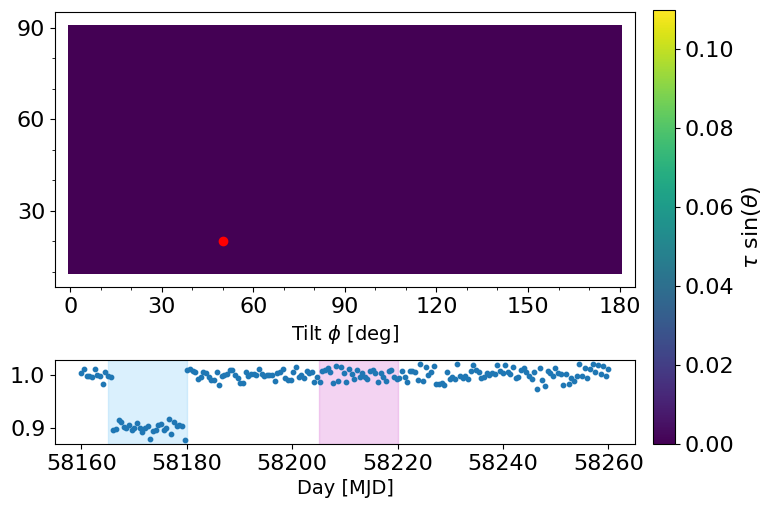

0.11000000000000001


In [5]:
### simdisk_c
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
fig2, f2_axes = plt.subplots(2,1, figsize=(8,6), gridspec_kw={'height_ratios':[4,1]})
(ax1,ax2) = f2_axes.flatten()

# sets the extent=() limits in imshow() so that the centre of each pixel corresponds to i and phi value
i_min = i_range.min()
i_max = i_range.max()
di = 0.5*((i_max-i_min)/(i_range.size-1))

phi_min = phi_range.min()
phi_max = phi_range.max()
dphi = 0.5*((phi_max-phi_min)/(phi_range.size-1))
f = 14


im1 = ax1.imshow(deltaf,
                 extent=(phi_min-dphi,phi_max+dphi,i_min-di,i_max+di),
                 vmin=0,
                 vmax=taudisk*1.1,
                 origin='lower')

ax1.set_xlabel(r"Tilt $ \phi $ [deg]", fontsize=14)

#ax1.set_title(r'$\tau\ \sin\ \theta$') #,fontsize=f)

ax1.scatter(50,20, color='red')

f = np.random.normal(1.0, f_sig, t.size)
f[indisk] = f[indisk] - taudisk

ax1.xaxis.set_major_locator(MultipleLocator(30))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax1.yaxis.set_major_locator(MultipleLocator(30))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
ax1.xaxis.set_minor_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(10))
#ax1.set_xlim(-10,190)
#ax1.set_ylim(-10,100)
ax1.set_xlim(-5,185)
ax1.set_ylim(5,95)



ax2.axvspan(58205, 58220, alpha=0.3, color= 'orchid')
ax2.axvspan(58205-offset_days, 58220-offset_days, alpha=0.3, color= 'lightskyblue')

ax2.scatter(t, f, s= 10)
ax2.set_xlabel("Day [MJD]", fontsize=14)

#if (offset_days == 0) or (offset_days ==5) or (offset_days ==20): #for 2 by 3 plot
if (offset_days == 0) or (offset_days ==10):
    ax2.set_ylabel("Normalized flux") 
    ax1.set_ylabel(r'Inclination $ \theta $ [deg]') 
#if (offset_days == 3) or (offset_days ==10) or (offset_days ==40): #for 2 by 3 plot
if (offset_days == 5) or (offset_days ==40):
    cbar = fig2.colorbar(im1, ax=f2_axes, label = r'$\tau\ \sin( \theta)$', fraction=0.035, pad=0.03,anchor =(0.0, 0.0))
    #cbar.formatter.set_powerlimits((0,0))

    
if (offset_days == 3) or (offset_days ==5):
    plt.savefig(f'Figures/CPD_sensitivity/mock_simdisk_b_offset_0{offset_days}.png') #, bbox_inches='tight')
else:
    plt.savefig(f'Figures/CPD_sensitivity/mock_simdisk_b_offset_{offset_days}.png') #, bbox_inches='tight')
plt.show()

print(taudisk*1.1)

In [6]:
"""3 by 2 plot"""

# from PIL import Image
# import glob

# import os
# from os import listdir
 
# fig, axes = plt.subplots(3,2, figsize=(14,12), sharex=False, sharey=False, gridspec_kw={ 'wspace':-0.3, 'hspace':0})
# for i, images in enumerate(np.sort(glob.glob('Figures/CPD_sensitivity/*.png'))):
#     x,y = i//2,i%2
#     img = Image.open(images)
#     axes[x,y].imshow(img) 
#     axes[x,y].axis("off")
    
#     numeric_filter = filter(str.isdigit, str(images))
#     numeric_string = "".join(numeric_filter)
#     numeric_string = [0,3,5,10,20,40,60]
#     if y==0: 
#         axes[x,y].text(100, 100, r" $\Delta$t"+f"= {numeric_string[i]}d", fontsize=12, c ='white',  fontweight='bold')
#     if y == 1:
#         axes[x,y].text(80, 100, r" $\Delta$t"+f"= {numeric_string[i]}d", fontsize=12, c ='white',  fontweight='bold')
# ## plt.savefig(f'Figures/CPD_sensitivity/sensitivity_CPD_mock_data_horizontal.pdf', bbox_inches='tight')
# plt.show()





'3 by 2 plot'

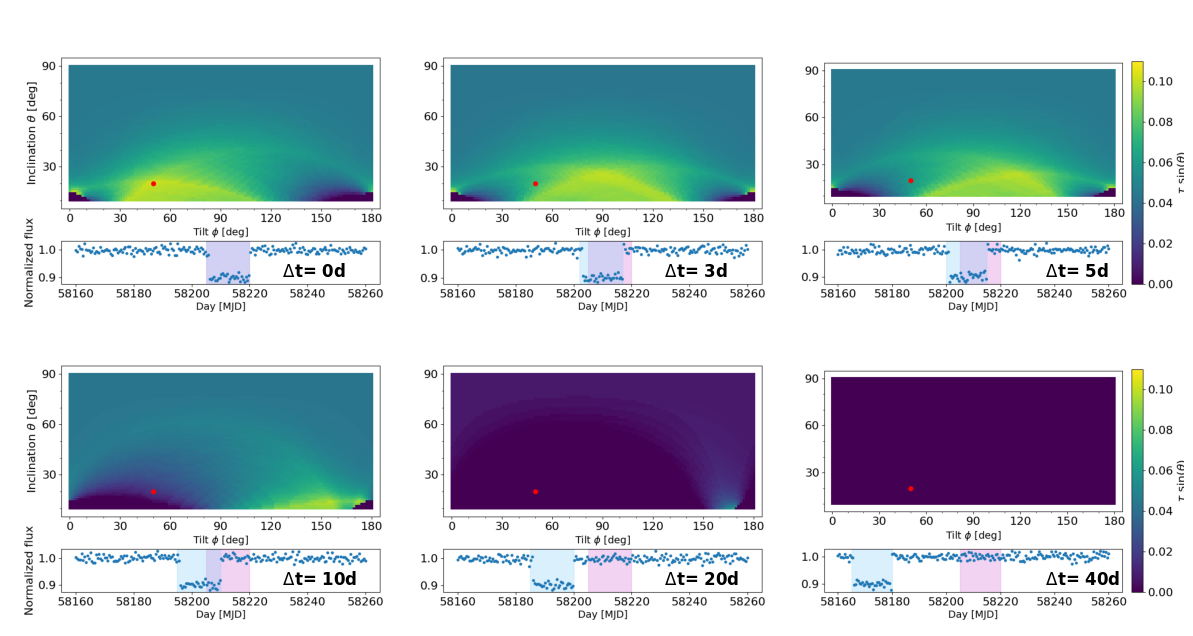

In [7]:
"""2 by 3 plot"""
from PIL import Image
import glob
 #figsize = (16.8)
fig, axes = plt.subplots(2,3, figsize=(16,8), sharex=False, sharey=False, gridspec_kw={ 'wspace':-0.2, 'hspace':-0.0})

for i, images in enumerate(np.sort(glob.glob('Figures/CPD_sensitivity/*.png'))):
    x,y = i//3,i%3
    img = Image.open(images)
    axes[x,y].imshow(img) 
    axes[x,y].axis("off")
    
    numeric_filter = filter(str.isdigit, str(images))
    numeric_string = "".join(numeric_filter)
    numeric_string = [0,3,5,10,20,40,60]
    axes[x,y].text(520,520, r" $\Delta$t"+f"= {numeric_string[i]}d", fontsize=12, c ='black',  fontweight='bold')
plt.savefig(f'Figures/CPD_sensitivity/sensitivity_CPD_mock_data_vertical.pdf', bbox_inches='tight')
plt.show()



